In [1]:
import os
import shutil
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1. Data set 준비

In [3]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = './class_activation_map/Annotation'

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


## 2. image unnormalization/visualization function

In [5]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

def visualize(sample):
    img_tensor, label, bbox = sample

    # 인덱스와 클래스 정보
    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    # 정규화 복원 전처리 시 사용한 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # tensor의 shape: (C, H, W) -> (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(3,3))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

def visualize_cam(cam,ax=None,title=""):
    if ax is None:
        ax = plt.gca()  # 현재 활성화된 축 사용
    
    im = ax.imshow(cam, cmap='jet')
    #ax.set_title("CAM")
    ax.set_title(title)
    ax.axis('off')

    return im


def visualize_cam_on_image(cam, img, alpha=0.5,ax=None,title=""):
    if ax is None:
        ax = plt.gca()  # 현재 활성화된 축 사용

    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    im = ax.imshow(overlay)
    ax.set_title(title)
    ax.axis('off')

    return im

## 3. CAM, Grad-CAM function

In [6]:
def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)

    # features[0]: shape [1, num_features, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

## 4. Detection(bounding box) with CAM and Grad-CAM function


In [7]:
def get_cam_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

RED=(255, 0, 0)
BLUE=(0, 0, 255)
GREEN=(0, 255, 0)
WHITE=(255, 255, 255)
def visualize_1bbox_on_image(img, bbox, box_color=WHITE, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), color=box_color, thickness=thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

## (실험1) CAM, Grad-CAM 비교

Label index: 0
Class name: n02085620-Chihuahua


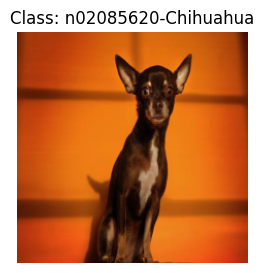

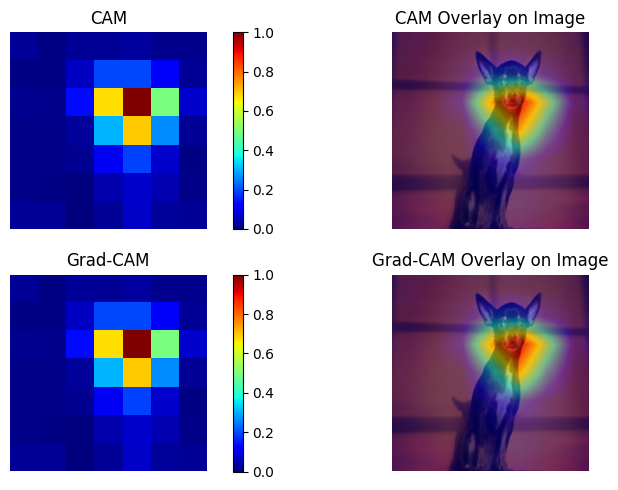

Diff. CAM, Grad-CAM:1.9818544387817383e-06
Label index: 20
Class name: n02091032-Italian_greyhound


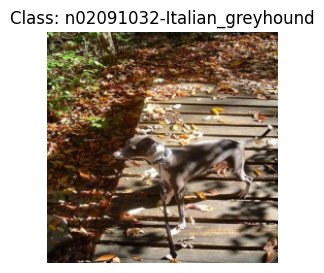

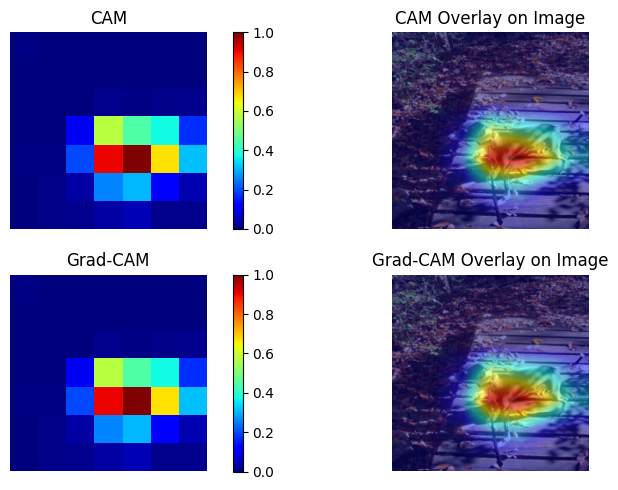

Diff. CAM, Grad-CAM:2.8695731089101173e-06


In [8]:
index=[10, 2000]

for i in index:
    ####################################
    # image, model 준비
    #----------------------------
    # image
    image, label, bbox = train_dataset[i]
    visualize((image, label, bbox))
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)           # 원본 이미지 복원

    # model
    cam_model_path = "./class_activation_map/cam_model.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(cam_model_path, map_location=device, weights_only=False)
    model.eval()  # 추론용이면 보통 eval 모드로

    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    ####################################
    # CAM Test
    #----------------------------
    # CAM
    cam = generate_cam(model, sample_image)

    # CAM + 원본 이미지 (overlay 시각화)
    im=visualize_cam(cam, ax=axes[0,0],title="CAM")                      # CAM 단독 시각화
    fig.colorbar(im,ax=axes[0,0])
    visualize_cam_on_image(cam, orig_img, ax=axes[0,1],title="CAM Overlay on Image")   # 원본 이미지 위에 CAM overlay 시각화


    ####################################
    #Grad-CAM Test
    #----------------------------
    # Grad-CAM (layer4 사용)
    grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

    # Grad-CAM + 원본 이미지 (overlay 시각화)
    im=visualize_cam(grad_cam, ax=axes[1,0],title="Grad-CAM")                     # Grad-CAM 단독 시각화
    fig.colorbar(im,ax=axes[1,0])
    visualize_cam_on_image(grad_cam, orig_img, ax=axes[1,1],title="Grad-CAM Overlay on Image")  # 원본 이미지 위에 Grad-CAM overlay 시각화
    plt.tight_layout()
    plt.show()

    ####################################
    # Difference CAM, Grad-CAM
    #----------------------------
    # CAM
    diff_cam=cam-grad_cam
    print(f'Diff. CAM, Grad-CAM:{np.sum(np.abs(diff_cam))}')
    print('===========================================')


## (실험2) "CAM, Grad-CAM, Ground truth" Bounding box 비교

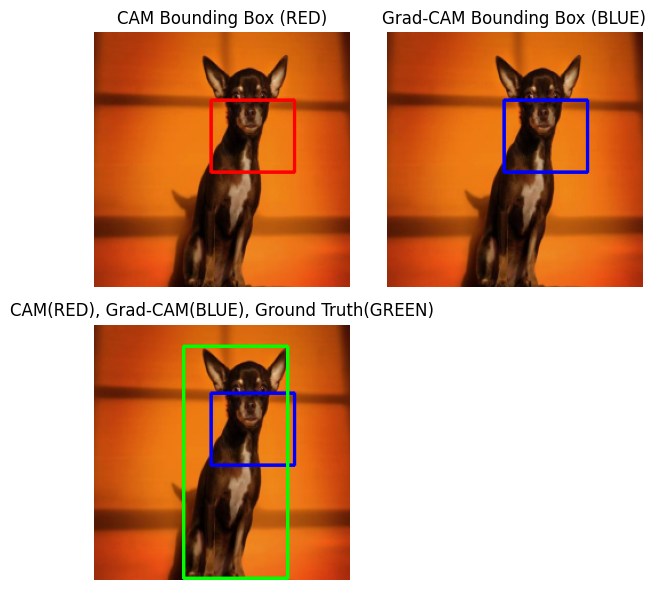

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

###############
# image
image, label, ground_truth = train_dataset[10]
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)           # 원본 이미지 복원
ground_bbox = [int(x) for x in ground_truth]


###############
# CAM
cam = generate_cam(model, sample_image)
cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
cam_bbox = get_cam_bbox(cam_resized, threshold=0.5) #(np.int64(78), np.int64(64), np.int64(143), np.int64(131))

img_cam_bbox = visualize_1bbox_on_image(orig_img, cam_bbox, box_color=RED)
axes[0,0].imshow(img_cam_bbox)
axes[0,0].set_title("CAM Bounding Box (RED)")
axes[0,0].axis("off")


###############
# Grad-CAM
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")
grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
grad_cam_bbox = get_cam_bbox(grad_cam_resized, threshold=0.5)

img_grad_bbox = visualize_1bbox_on_image(orig_img, grad_cam_bbox, box_color=BLUE)
axes[0,1].imshow(img_grad_bbox)
axes[0,1].set_title("Grad-CAM Bounding Box (BLUE)")
axes[0,1].axis("off")


###############
# CAM, Grad-CAM, Ground truth
img_cam_bbox = visualize_1bbox_on_image(orig_img, cam_bbox, box_color=RED)
img_cam_grad_bbox = visualize_1bbox_on_image(img_cam_bbox, grad_cam_bbox, box_color=BLUE)
img_cam_grad_ground_bbox = visualize_1bbox_on_image(img_cam_grad_bbox, ground_bbox, box_color=GREEN)
axes[1,0].imshow(img_cam_grad_ground_bbox)
axes[1,0].set_title("CAM(RED), Grad-CAM(BLUE), Ground Truth(GREEN)")
axes[1,0].axis("off")

axes[1,1].axis("off")

plt.tight_layout()
plt.show()

In [10]:
print(f'                  IoU=\t{get_iou(cam_bbox, ground_bbox)}')
print(f'     cam bounding box=\t{cam_bbox}')
print(f'grad-cam bounding box=\t{grad_cam_bbox}')
print(f'  ground bounding box=\t{ground_bbox}')

                  IoU=	0.22391385072409953
     cam bounding box=	(np.int64(102), np.int64(60), np.int64(175), np.int64(123))
grad-cam bounding box=	(np.int64(102), np.int64(60), np.int64(175), np.int64(123))
  ground bounding box=	[78, 19, 169, 222]


## (실험3) Layer별 Grad-CAM 비교

Label index: 0
Class name: n02085620-Chihuahua


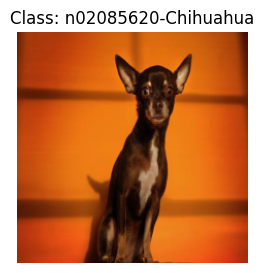

============Grad-CAM Test==============


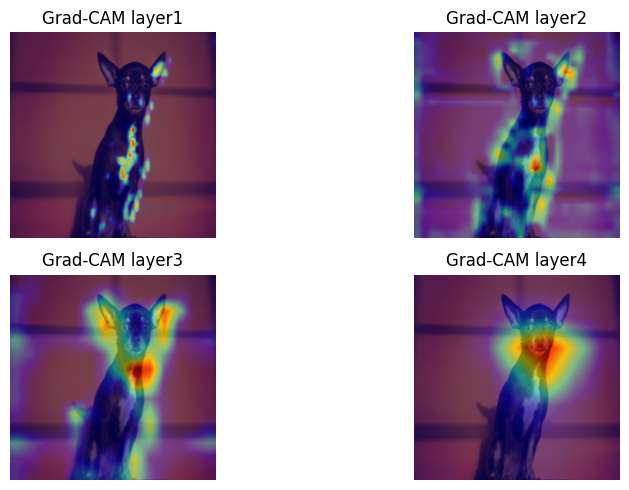

#############################################################
Label index: 10
Class name: n02088238-basset


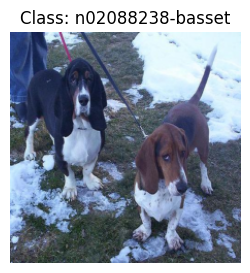

============Grad-CAM Test==============


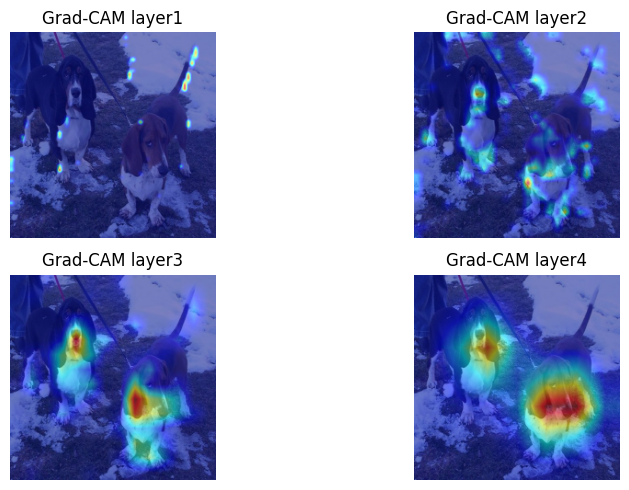

#############################################################
Label index: 20
Class name: n02091032-Italian_greyhound


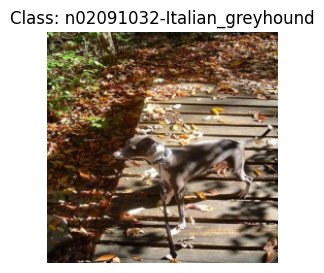

============Grad-CAM Test==============


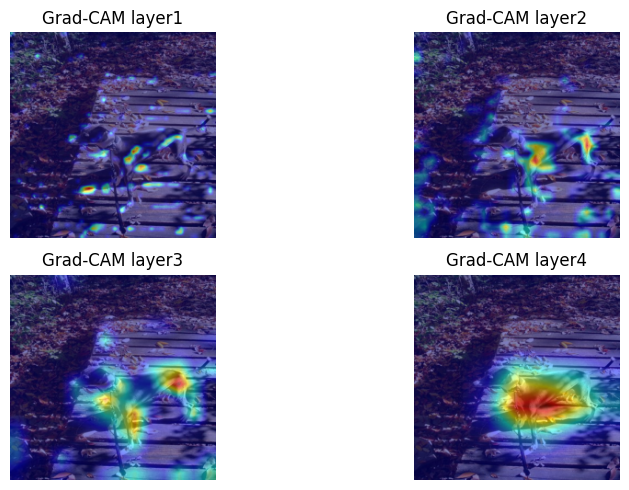

#############################################################


In [11]:
index=[10, 1000, 2000]

for i in index:
    ####################################
    # image, model 준비
    #----------------------------
    # image
    image, label, bbox = train_dataset[i]
    visualize((image, label, bbox))
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)           # 원본 이미지 복원

    # model
    cam_model_path = "./class_activation_map/cam_model.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(cam_model_path, map_location=device, weights_only=False)
    model.eval()  # 추론용이면 보통 eval 모드로

    ####################################
    #Grad-CAM
    #----------------------------
    print('============Grad-CAM Test==============')
    # Grad-CAM (layer4 사용)
    grad_cam_ly1 = generate_grad_cam(model, sample_image, target_layer_name="layer1")
    grad_cam_ly2 = generate_grad_cam(model, sample_image, target_layer_name="layer2")
    grad_cam_ly3 = generate_grad_cam(model, sample_image, target_layer_name="layer3")
    grad_cam_ly4 = generate_grad_cam(model, sample_image, target_layer_name="layer4")

    # Grad-CAM + 원본 이미지 (overlay 시각화)
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    visualize_cam_on_image(grad_cam_ly1, orig_img, ax=axes[0,0],title="Grad-CAM layer1")
    visualize_cam_on_image(grad_cam_ly2, orig_img, ax=axes[0,1],title="Grad-CAM layer2")
    visualize_cam_on_image(grad_cam_ly3, orig_img, ax=axes[1,0],title="Grad-CAM layer3")
    visualize_cam_on_image(grad_cam_ly4, orig_img, ax=axes[1,1],title="Grad-CAM layer4")

    plt.tight_layout()
    plt.show()
    print('#############################################################')

## (실험4) Grad-CAM 음수, 절대값 비교

In [12]:
def generate_grad_cam_compar(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam_ori = grad_cam.cpu().numpy()

    # ReLU 적용
    grad_cam = np.maximum(grad_cam_ori, 0)              #음수 값 제거
    grad_cam_minus = np.minimum(grad_cam_ori, 0)*-1.0   #양수 값 제거
    grad_cam_abs  = np.abs(grad_cam_ori)                #절대값 처리

    # 정규화: [0,1] 범위로 스케일링
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)
    grad_cam_minus = (grad_cam_minus - grad_cam_minus.min()) / (grad_cam_minus.max() - grad_cam_minus.min() + 1e-8)
    grad_cam_abs = (grad_cam_abs - grad_cam_abs.min()) / (grad_cam_abs.max() - grad_cam_abs.min() + 1e-8)

    return grad_cam, grad_cam_minus, grad_cam_abs

Label index: 20
Class name: n02091032-Italian_greyhound


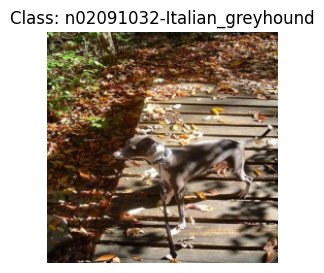

============Grad-CAM Test==============


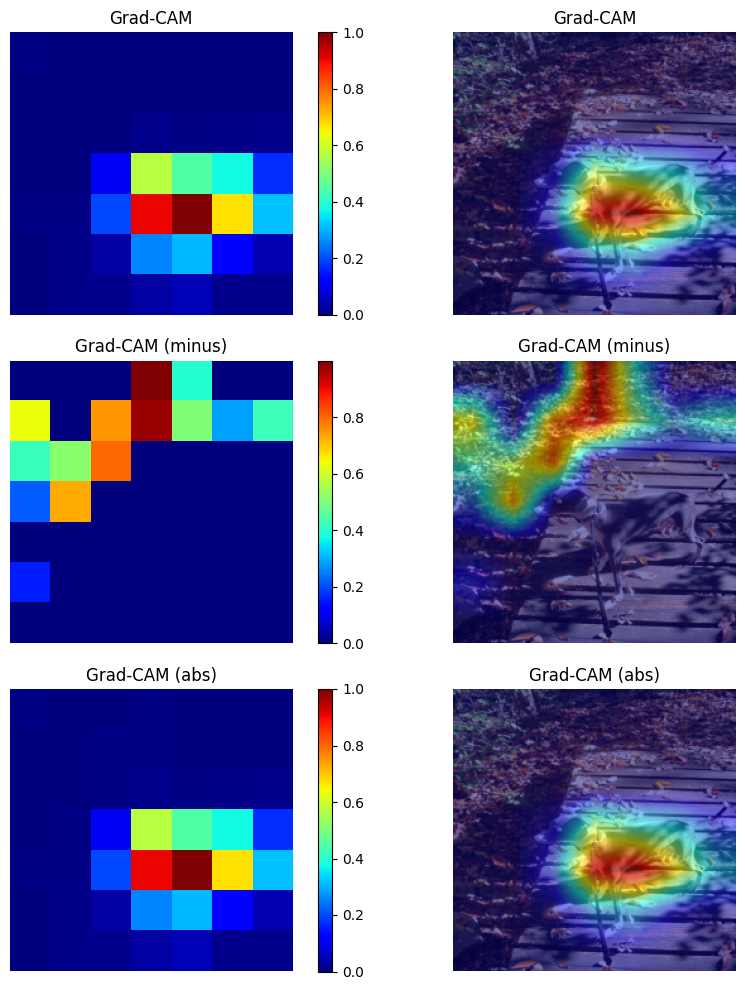

In [13]:
####################################
# image, model 준비
#----------------------------
# image
image, label, bbox = train_dataset[2000]
visualize((image, label, bbox))
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)           # 원본 이미지 복원

# model
cam_model_path = "./class_activation_map/cam_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(cam_model_path, map_location=device, weights_only=False)
model.eval()  # 추론용이면 보통 eval 모드로

####################################
#Grad-CAM Test
#----------------------------
print('============Grad-CAM Test==============')
# Grad-CAM (layer4 사용)
grad_cam,grad_cam_minus,grad_cam_abs = generate_grad_cam_compar(model, sample_image, target_layer_name="layer4")

# Grad-CAM + 원본 이미지 (overlay 시각화)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
im=visualize_cam(grad_cam, ax=axes[0,0],title="Grad-CAM")                     # Grad-CAM 단독 시각화
fig.colorbar(im,ax=axes[0,0])
visualize_cam_on_image(grad_cam, orig_img, ax=axes[0,1],title="Grad-CAM")  # 원본 이미지 위에 Grad-CAM overlay 시각화

im=visualize_cam(grad_cam_minus, ax=axes[1,0],title="Grad-CAM (minus)")                     # Grad-CAM 단독 시각화
fig.colorbar(im,ax=axes[1,0])
visualize_cam_on_image(grad_cam_minus, orig_img, ax=axes[1,1],title="Grad-CAM (minus)")  # 원본 이미지 위에 Grad-CAM overlay 시각화

im=visualize_cam(grad_cam_abs, ax=axes[2,0],title="Grad-CAM (abs)")                     # Grad-CAM 단독 시각화
fig.colorbar(im,ax=axes[2,0])
visualize_cam_on_image(grad_cam_abs, orig_img, ax=axes[2,1],title="Grad-CAM (abs)")  # 원본 이미지 위에 Grad-CAM overlay 시각화


plt.tight_layout()
plt.show()

# == 결과 분석 및 고찰 ================

### (실험 사전 준비) 실험은 model이 수렴하게 학습 후 저장된 model 결과를 사용하였다.
### (실험1) CAM, Grad-CAM 비교
<img src='ex01.png' width='600'>

- 개의 인식을 위해 코 주변과 몸통 주변의 특징이 부각됨을 알 수 있다.
- CAM과 Grad-CAM의 차이는 거의0 에 수렴하는 것을 확인 할 수 있다.
     - (그림 하단부 CAM과 Grad-CAM 차이의 '절대값 합' 결과)
     - 이는 model이 CNN-GAP-FC 로 이어지는 구조이므로 CAM과 Grad-CAM이 같은 동작을 하기 때문이다.
     - 만약, CNN-GAP-FC 로 이어지는 구조가 아니면, CAM은 동작을 위해 별도의 레이어를 구성/학습해야 하므로 부각되는 위치는 비슷할지라도 다른 수치 결과가 나올 수 있다.

### (실험2) "CAM, Grad-CAM, Ground truth" Bounding box 비교
<img src='ex02.png' width='500'>

- CAM과 Grad-CAM의 bounding box를 확인한 결과 같은 값을 나타내었다.(threshold 동일)
     - 이는 앞서 언급한 것 처럼 model이 CNN-GAP-FC 로 이어지는 구조이므로 CAM과 Grad-CAM이 같은 동작을 하기 때문이다.
- IoU 결과는 0.22(22%)로 낮게 나왔다. 이는 ground truth는 개체의 전체를 영역으로 하는 반면, model은 개체의 유/무를 판단하기 위해, 개체의 일부 특징에 집중하기 때문으로 보인다.

### (실험3) Layer별 Grad-CAM 비교
<img src='ex03.png' width='900'>

- 입력 layer부터 출력까지 Grad-CAM을 확인한 결과 model이 집중하는 특징이 전체로 퍼져있다가 점점 한점으로 모이는 것을 볼 수 있다.
     - 이는 layer 초기에는 단순한 형상(점,선,면 등)을 feature로 추출하고 receptive field가 좁지만, 뒤로 갈 수록 복잡한 형상(코, 눈, 다리 등)을 fearture로 추출하고 receptive field가 넓어지므로 나타나는 결과이다.

### (실험4) Grad-CAM 음수, 절대값 비교
<img src='ex04.png' width='400'>

- CAM/Grad-CAM은 결과를 계산한 후 ReLU를 통과시켜 양수만으로 구성한다. 그럼 음수는 어떤 의미인가?
     - model 추론 결과에 영향을 미치는 부분은 CAM에서 양수로 표시되며, 이는 kernel에 의해 증폭되는 특징을 뜻한다. 반대로 생각하면 음수로 표시되는 부분은 kernel에 의해 강하게 배제되는 부분이라고 볼 수도 있다.
     - 테스트 이미지에서는 위쪽 배경이 이러한 결과를 보인다.
     - 하지만, 절대값으로 Grad-CAM의 결과를 표시해본 결과 음수 영역은 그 크기가 매우 작아서 거의 영향을 미치지 않음을 확인할 수 있다. 따라서, 특별히 의미를 부여하기 보다는 연산결과 나오는 부산물 정도로 생각된다.

### (고찰)
- 이번 실험에서는 model이 CNN-GAP-FC 로 이어지는 구조를 사용하였으므로 model 결과에 대한 CAM과 Grad-CAM의 동작은 같게 나타났고, 추가적인 layer 생성/학습은 필요하지 않았다.
- 하지만, 이러한 구조가 아닌경우 CAM은 별도의 layer를 추가로 구성/학습이 필요하므로 Grad-CAM이 보다 효과적인 방법으로 보인다.
- 또한, Grad-CAM은 layer 중간중간의 진행사항도 파악할 수 있다는 장점을 가진다.
- 뿐만아니라, CAM의 경우 CNN-GAP-FC 의 구조가 아니면, 별도의 layer 추가 구성/학습이 필요하므로, 이 과정에서 불필요한 왜곡이 나타날 수 도 있다는 단점을 가진다.
- 이번 실험에서는 객체의 유/무를 판단하는 model 이었으므로, CAM/Grad-CAM으로 detection box를 추출하여 IoU를 비교하는것은 큰 의미가 없었다고 생각한다. 객체의 유/무를 판단하기 위해서는 객체의 일부 도드라지는 특징만을 사용해도 충분하기 때문이다. 실제로 CAM/Grad-CAM에서 추출한 detection box는 객체의 일부 영역만을 나타내고 있다.
- Grad-CAM/CAM의 음수 영역을 추가로 고찰해 볼 수 있었다.
     - model 추론 결과에 영향을 미치는 부분은 CAM에서 양수로 표시되며, 이는 kernel에 의해 증폭되는 특징을 뜻한다. 반대로 생각하면 음수로 표시되는 부분은 kernel에 의해 강하게 배제되는 부분이라고 볼 수도 있다.
     - 하지만, 절대값으로 Grad-CAM의 결과를 표시해본 결과 음수 영역은 그 크기가 매우 작아서 거의 영향을 미치지 않음을 확인할 수 있다. 따라서, 특별히 의미를 부여하기 보다는 연산결과 나오는 부산물 정도로 생각된다.